# Medicamentos MUBICS

In [36]:
#install.packages("class")
#install.packages("caret")
#install.packages("codetools")
#install.packages("neuralnet")
#install.packages("e1071")
#install.packages("janitor")
library(dplyr)
library(readxl)
library(randomForest)
library(class)
library(caret)
library(e1071)
library(neuralnet)
library(janitor)
#Obtemos la base de datos original
dataset <- read_excel("dataset_Chembl_Cytokines.xlsx")
head(dataset, 4)


CMPD_CHEMBLID,CANONICAL_SMILES,PROTEIN_ACCESSION,STANDARD_TYPE_UNITSj,STANDARD_VALUE,ASSAY_ORGANISM,ORGANISM
CHEMBL117109,Fc1ccc(cc1)c2nc3ccccn3c2C4=NN(C(=O)C=C4)c5c(Cl)cccc5Cl,O15264,Inhibition (%),60,Homo sapiens,Homo sapiens
CHEMBL357732,Cc1ccccc1C(=O)c2ccc(Nc3ccccc3N)cc2,O15264,IC50 (nM),47,Homo sapiens,Homo sapiens
CHEMBL325597,CCCn1c(SC)nc(c2ccc(F)cc2)c1c3ccncc3,O15264,IC50 (nM),1300,Homo sapiens,Homo sapiens
CHEMBL94487,CC(C)(C)c1onc(NC(=O)Nc2ccc(Oc3ccccc3)cc2)c1,O15264,IC50 (nM),360,Escherichia coli,Homo sapiens


In [37]:
#Filtramos la base de datos para tener solo los valores referentes a IC50 y Homo Sapiens
medicamentos<- filter(dataset,dataset$STANDARD_TYPE_UNITSj=="IC50 (nM)")
medicamentos<- filter(medicamentos,medicamentos$ASSAY_ORGANISM=="Homo sapiens")
#Creamos un data frame con las columnas id, smiles y value
medicamentos <- data.frame("chemblid"= medicamentos$CMPD_CHEMBLID,
                           "smiles" = medicamentos$CANONICAL_SMILES,  "value" = medicamentos$STANDARD_VALUE)
head(medicamentos, 4)
#PONER COMENTADAS LAS LINEAS PARA OBTENER LOS MARCADORES

chemblid,smiles,value
CHEMBL357732,Cc1ccccc1C(=O)c2ccc(Nc3ccccc3N)cc2,47
CHEMBL325597,CCCn1c(SC)nc(c2ccc(F)cc2)c1c3ccncc3,1300
CHEMBL425494,COc1ccc(N2C(=O)Nc3c2ncnc3c4ccccc4C)c(OC)c1,5200
CHEMBL103667,Cc1ccc(cc1)n2nc(cc2NC(=O)Nc3ccc(OCCN4CCOCC4)c5ccccc35)C(C)(C)C,9


In [25]:
#Obtenemos los SMILES y calculamos los descriptores
#smiles <- medicamentos$smiles
#vectorDescriptores <- data.frame()
#library(rcdk)
#for(i in 1:length(smiles)) {
#  anle138b = parse.smiles(as.vector(smiles[i]))
#  descriptors = get.desc.names(type="all")
#  descriptorsvalues = eval.desc(anle138b,descriptors)
#  vectorDescriptores <- rbind(vectorDescriptores,descriptorsvalues)
#}

In [38]:
#cargamos descriptores moleculares
vectorDescriptores <- read.csv("vectorDescriptores.csv")
#eliminamos columnas con valores constantes (también se eliminan las columnas de NA's)
vectorDescriptores <- remove_constant(vectorDescriptores, na.rm=FALSE)
#eliminamos filas con valores nulos (10); también se eliminan esas mismas filas en medicamentos
medicamentos <- medicamentos[complete.cases(vectorDescriptores),]
vectorDescriptores <- vectorDescriptores[complete.cases(vectorDescriptores),]

head(vectorDescriptores,4)

CanonicalSmiles,nSmallRings,nAromRings,nRingBlocks,nAromBlocks,nRings3,nRings4,nRings5,nRings6,nRings7,...,ATSc4,ATSc5,nAtom,nAromBond,naAromAtom,apol,ALogP,ALogp2,AMR,nAcid
Cc1ccccc1C(=O)c2ccc(Nc3ccccc3N)cc2,3,3,3,3,0,0,0,3,0,...,0.03290936,-0.01109213,41,18,18,50.20427,4.7787,22.83597,94.7111,0
CCCn1c(SC)nc(c2ccc(F)cc2)c1c3ccncc3,3,3,3,3,0,0,1,2,0,...,-0.04867077,-0.02404886,41,17,17,50.43927,3.6182,13.09137,91.8774,0
COc1ccc(N2C(=O)Nc3c2ncnc3c4ccccc4C)c(OC)c1,4,4,3,3,0,0,1,3,0,...,-0.08995467,-0.05025407,45,22,21,54.00827,4.7696,22.74908,97.5147,0
Cc1ccc(cc1)n2nc(cc2NC(=O)Nc3ccc(OCCN4CCOCC4)c5ccccc35)C(C)(C)C,5,4,4,3,0,0,1,4,0,...,0.21593668,-0.06937263,76,22,21,87.13734,6.3694,40.56926,151.6981,0


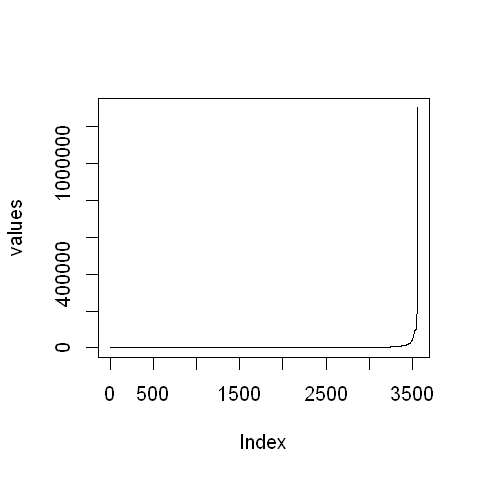

In [39]:
#Comprobemos la distribucion de los valores de IC50
values=sort(medicamentos$value)
plot(values,type="l")
options(repr.plot.width=4, repr.plot.height=4)

In [40]:
#Decidimos un punto de separacion entre valores IC50 altos (HIGH) y bajos (LOW)

median(values)
#Debido a la distribución de los datos la mediana no es fiable, ya que los valores se mantienen bajos
#hasta llegar al último 10% de los datos

[1] 93

In [41]:
#La media se ajusta un poco más
mean(values)

[1] 3372.067

In [30]:
#También se puede escojer como punto de separación, el punto medio de la curva de crecimiento que se ve en
#la gráfica. La posición 3500 (aprox)
#values[3500]

In [42]:
#utilizamos la media como umbral para definir las clases IC50LOW (1) e IC50HIGH (0)
valorTeorico = 1000 # <1001 lo consideraremos IC50bajo
#tmp <- ifelse(medicamentos$value < mean(medicamentos$value), 1, 0)
vectorClase <- ifelse(medicamentos$value < valorTeorico, 1, 0)
#vectorDescriptores$class <- vectorClase

smiles=vectorDescriptores$CanonicalSmiles
vectorDescriptores$CanonicalSmiles <- NULL

#eliminamos las columnas que tienen una alta correlación
correlationMatrix <- cor(vectorDescriptores)
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff = 0.75)
vectorDescriptores <- vectorDescriptores[,-highlyCorrelated]

head(vectorDescriptores,4)

nSmallRings,nAromRings,nRingBlocks,nRings4,nRings6,nRings7,tpsaEfficiency,XLogP,LipinskiFailures,nRotB,...,BCUTc.1h,BCUTp.1l,BCUTp.1h,nBase,ATSm1,ATSc2,ATSc3,ATSc4,ATSc5,nAcid
3,3,3,0,3,0,0.1824308,4.408,0,4,...,0.1932216,5.629999,9.956377,0,24.49443,-0.06168846,-0.04146567,0.03290936,-0.01109213,0
3,3,3,0,2,0,0.1712213,4.925,0,5,...,0.1484494,4.106970,12.279637,0,31.70974,-0.18828574,0.09048650,-0.04867077,-0.02404886,0
4,4,3,0,3,0,0.2114664,2.899,0,4,...,0.2895590,4.843840,10.902306,0,30.76333,-0.47927367,0.21621327,-0.08995467,-0.05025407,0
5,4,4,0,4,0,0.1519658,5.114,1,10,...,0.2816755,5.306436,10.715837,1,43.12331,-0.39556151,-0.08988765,0.21593668,-0.06937263,0


In [43]:
#Clasificacion para knn
n = 10 #número de modelos para hacer la media
precisionMedia = 0
sensibilidadMedia = 0
especifidadMedia = 0
exactitudMedia = 0
for(i in 1:n) {
    #version cutre de división de grupos
    nEntrenamiento = round(0.8 * nrow(vectorDescriptores))
    entrenamiento<-sample(1:nrow(vectorDescriptores),nEntrenamiento)
    conjunto_entrenamiento<-vectorDescriptores[entrenamiento,]
    conjunto_test<-vectorDescriptores[-entrenamiento,]
    y = vectorClase[entrenamiento]
    #Clasificacion para knn
    prediccionTest <- knn(conjunto_entrenamiento,conjunto_test,cl=factor(y),k=7, l=0, prob=FALSE, use.all=TRUE)
    #vectorDescriptores$class <- vectorClase
    #Obtenemos las clases de los datos de entrenamiento
    validacionTest <- vectorClase[-entrenamiento]
    confmatrix <- caret::confusionMatrix(table(prediccionTest, validacionTest))
    precisionMedia = precisionMedia + confmatrix$overall[1]
    sensibilidadMedia = sensibilidadMedia + confmatrix$byClass[1]
    especifidadMedia = especifidadMedia + confmatrix$byClass[2]
    exactitudMedia = exactitudMedia + confmatrix$byClass[5]
}
confmatrix
round((precisionMedia/n),3) #precisión
round((sensibilidadMedia/n),3) #sensibilidad
round((especifidadMedia/n),3) #especifidad
round((exactitudMedia/n),3) #exactitud


Confusion Matrix and Statistics

              validacionTest
prediccionTest   0   1
             0  46  51
             1 118 497
                                          
               Accuracy : 0.7626          
                 95% CI : (0.7296, 0.7935)
    No Information Rate : 0.7697          
    P-Value [Acc > NIR] : 0.6899          
                                          
                  Kappa : 0.2187          
                                          
 Mcnemar's Test P-Value : 3.836e-07       
                                          
            Sensitivity : 0.28049         
            Specificity : 0.90693         
         Pos Pred Value : 0.47423         
         Neg Pred Value : 0.80813         
             Prevalence : 0.23034         
         Detection Rate : 0.06461         
   Detection Prevalence : 0.13624         
      Balanced Accuracy : 0.59371         
                                          
       'Positive' Class : 0               
         

Accuracy 
   0.758

Sensitivity 
      0.246

Specificity 
       0.91

Precision 
    0.447

In [44]:
#Clasificacion para random forest
n = 2 #número de modelos para hacer la media
precisionMedia = 0
sensibilidadMedia = 0
especifidadMedia = 0
exactitudMedia = 0
for(i in 1:n) {
    #version cutre de división de grupos
    nEntrenamiento = round(0.8 * nrow(vectorDescriptores))
    entrenamiento<-sample(1:nrow(vectorDescriptores),nEntrenamiento)
    conjunto_entrenamiento<-vectorDescriptores[entrenamiento,]
    conjunto_test<-vectorDescriptores[-entrenamiento,]
    y = as.factor(vectorClase[entrenamiento])
    #Clasificacion para random forest
    conjunto_entrenamiento$clase <- y
    modeloRF <- randomForest(clase ~ . , data = conjunto_entrenamiento, mtry=9)
    prediccionTest <- predict(modeloRF, conjunto_test, type = "class") 
    #Obtenemos las clases de los datos de entrenamiento
    validacionTest <- vectorClase[-entrenamiento]
    #caret::confusionMatrix(predicho, valoresReales)
    #tabla <- table(predicho, validacionTest)
    #tabla
    confmatrix <- caret::confusionMatrix(table(prediccionTest, validacionTest))
    precisionMedia = precisionMedia + confmatrix$overall[1]
    sensibilidadMedia = sensibilidadMedia + confmatrix$byClass[1]
    especifidadMedia = especifidadMedia + confmatrix$byClass[2]
    exactitudMedia = exactitudMedia + confmatrix$byClass[5]
}
confmatrix
round((precisionMedia/n),3) #precisión
round((sensibilidadMedia/n),3) #sensibilidad
round((especifidadMedia/n),3) #especifidad
round((exactitudMedia/n),3) #exactitud

Confusion Matrix and Statistics

              validacionTest
prediccionTest   0   1
             0  89  30
             1  86 507
                                          
               Accuracy : 0.8371          
                 95% CI : (0.8079, 0.8635)
    No Information Rate : 0.7542          
    P-Value [Acc > NIR] : 5.31e-08        
                                          
                  Kappa : 0.5074          
                                          
 Mcnemar's Test P-Value : 3.28e-07        
                                          
            Sensitivity : 0.5086          
            Specificity : 0.9441          
         Pos Pred Value : 0.7479          
         Neg Pred Value : 0.8550          
             Prevalence : 0.2458          
         Detection Rate : 0.1250          
   Detection Prevalence : 0.1671          
      Balanced Accuracy : 0.7264          
                                          
       'Positive' Class : 0               
         

Accuracy 
   0.836

Sensitivity 
      0.512

Specificity 
      0.936

Precision 
     0.71

In [45]:
#Clasificacion para SVM
n = 10 #número de modelos para hacer la media
precisionMedia = 0
sensibilidadMedia = 0
especifidadMedia = 0
exactitudMedia = 0
for(i in 1:n) {
    #version cutre de división de grupos
    nEntrenamiento = round(0.8 * nrow(vectorDescriptores))
    entrenamiento<-sample(1:nrow(vectorDescriptores),nEntrenamiento)
    conjunto_entrenamiento<-vectorDescriptores[entrenamiento,]
    conjunto_test<-vectorDescriptores[-entrenamiento,]
    y = as.factor(vectorClase[entrenamiento])
    #Clasificacion para random forest
    conjunto_entrenamiento$clase <- y
    suppressWarnings(modeloSVM <- svm(clase ~ . , data = conjunto_entrenamiento, type = "C-classification", kernel = "radial",degree = 3, gamma = 0.25))
    prediccionTest <- predict(modeloSVM, conjunto_test, type = "class") 
    #Obtenemos las clases de los datos de entrenamiento
    validacionTest <- vectorClase[-entrenamiento]
    #caret::confusionMatrix(predicho, valoresReales)
    #tabla <- table(predicho, validacionTest)
    #tabla
    confmatrix <- caret::confusionMatrix(table(prediccionTest, validacionTest))
    precisionMedia = precisionMedia + confmatrix$overall[1]
    sensibilidadMedia = sensibilidadMedia + confmatrix$byClass[1]
    especifidadMedia = especifidadMedia + confmatrix$byClass[2]
    exactitudMedia = exactitudMedia + confmatrix$byClass[5]
}
confmatrix
round((precisionMedia/n),3) #precisión
round((sensibilidadMedia/n),3) #sensibilidad
round((especifidadMedia/n),3) #especifidad
round((exactitudMedia/n),3) #exactitud

Confusion Matrix and Statistics

              validacionTest
prediccionTest   0   1
             0  45  22
             1  95 550
                                          
               Accuracy : 0.8357          
                 95% CI : (0.8064, 0.8622)
    No Information Rate : 0.8034          
    P-Value [Acc > NIR] : 0.01546         
                                          
                  Kappa : 0.3523          
                                          
 Mcnemar's Test P-Value : 2.806e-11       
                                          
            Sensitivity : 0.3214          
            Specificity : 0.9615          
         Pos Pred Value : 0.6716          
         Neg Pred Value : 0.8527          
             Prevalence : 0.1966          
         Detection Rate : 0.0632          
   Detection Prevalence : 0.0941          
      Balanced Accuracy : 0.6415          
                                          
       'Positive' Class : 0               
         

Accuracy 
    0.81

Sensitivity 
      0.293

Specificity 
      0.958

Precision 
    0.663

In [46]:
#Clasificacion para regresión logística
n = 2 #número de modelos para hacer la media
precisionMedia = 0
sensibilidadMedia = 0
especifidadMedia = 0
exactitudMedia = 0
for(i in 1:n) {
    #version cutre de división de grupos
    nEntrenamiento = round(0.8 * nrow(vectorDescriptores))
    entrenamiento<-sample(1:nrow(vectorDescriptores),nEntrenamiento)
    conjunto_entrenamiento<-vectorDescriptores[entrenamiento,]
    conjunto_test<-vectorDescriptores[-entrenamiento,]
    y = vectorClase[entrenamiento]
    #Clasificacion para regresión logística
    conjunto_entrenamiento$clase <- y
    modelo <- glm(conjunto_entrenamiento$clase ~ .,
                family = binomial(logit), data=conjunto_entrenamiento)
    prediccionTest<-predict(modelo, conjunto_test, type="response")
    prediccionTest <- ifelse(prediccionTest > 0.5, 1, 0)
    #vectorDescriptores$class <- vectorClase
    #Obtenemos las clases de los datos de entrenamiento
    validacionTest <- vectorClase[-entrenamiento]
    confmatrix <- caret::confusionMatrix(table(prediccionTest, validacionTest))
    precisionMedia = precisionMedia + confmatrix$overall[1]
    sensibilidadMedia = sensibilidadMedia + confmatrix$byClass[1]
    especifidadMedia = especifidadMedia + confmatrix$byClass[2]
    exactitudMedia = exactitudMedia + confmatrix$byClass[5]
}
confmatrix
round((precisionMedia/n),3) #precisión
round((sensibilidadMedia/n),3) #sensibilidad
round((especifidadMedia/n),3) #especifidad
round((exactitudMedia/n),3) #exactitud

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

Confusion Matrix and Statistics

              validacionTest
prediccionTest   0   1
             0  61  32
             1 112 507
                                          
               Accuracy : 0.7978          
                 95% CI : (0.7663, 0.8267)
    No Information Rate : 0.757           
    P-Value [Acc > NIR] : 0.005651        
                                          
                  Kappa : 0.3478          
                                          
 Mcnemar's Test P-Value : 4.6e-11         
                                          
            Sensitivity : 0.35260         
            Specificity : 0.94063         
         Pos Pred Value : 0.65591         
         Neg Pred Value : 0.81906         
             Prevalence : 0.24298         
         Detection Rate : 0.08567         
   Detection Prevalence : 0.13062         
      Balanced Accuracy : 0.64662         
                                          
       'Positive' Class : 0               
         

Accuracy 
   0.803

Sensitivity 
      0.381

Specificity 
      0.932

Precision 
    0.632